In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import tifffile
import random


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from random import choices

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

from seaborn import heatmap

print(tf.executing_eagerly())
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('GPUs available: {}'.format(physical_devices))

True
2.2.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model = tf.keras.models.load_model("sentinel+UnsupervisedFeatureLearning20210317-162239+w3+K100K900+M411M3600_ZCANormTrue_Seed0")

In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 4)]  0                                            
__________________________________________________________________________________________________
feature_map_layer_4 (FeatureMap (None, 62, 62, 100)  7200        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 31, 31, 100)  0           feature_map_layer_4[0][0]        
__________________________________________________________________________________________________
feature_map_layer_5 (FeatureMap (None, 29, 29, 900)  1620000     max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [4]:
def open_image(image_loc, expected_dim):
    pixel_data = tifffile.imread(image_loc)
    
    height = pixel_data.shape[0]
    width = pixel_data.shape[1]
    channels = pixel_data.shape[2]

    if width != height :
        print('Image {} is not square, returning empty variable'.format(image_loc))
        return None
    
    if width != expected_dim:
        print('Image {} has dimension {}, expected {}, returning empty variable'.format(image_loc, width, expected_dim))
        return None
    
    return pixel_data / 10000 #Normalised

def load_test_data_to_numpy(data_dir):
    data = []
    labels = []
    
    for image_loc in os.listdir(data_dir):
        data.append(open_image(data_dir + image_loc, 64))
        
        if image_loc.startswith('inf'):
            labels.append(1)
        else:
            labels.append(0)
        
    return np.stack(data), np.stack(labels)


In [5]:
data_dir = "data/sentinel_labelled/"
data_numpy, labels = load_test_data_to_numpy(data_dir)

num_images = data_numpy.shape[0]
image_size = data_numpy.shape[1]
no_channels = data_numpy.shape[3]

In [6]:
%%time
scale_images = False
seed=0
svm_params = {'kernel':'linear', 'random_state':seed, 'C':1}

scene_embeddings = []

mean = data_numpy.mean(axis=0)
std = np.std(data_numpy, axis=0)

data_scaled = (data_numpy - mean)/std

for i in range(num_images):
    if scale_images:
        scene_embedding = np.array(model(data_scaled[i:i+1]))
    else:
        scene_embedding = np.array(model(data_numpy[i:i+1]))
        
    scene_embeddings.append(scene_embedding.flatten())
    
scene_embeddings = np.stack(scene_embeddings)

CPU times: user 889 ms, sys: 925 ms, total: 1.81 s
Wall time: 2.77 s


In [7]:
data_numpy.shape[0]

149

In [8]:
%%time
no_trials = 1000

train_scores=[]
test_scores=[]
f1_scores=[]

random.seed(seed)

for _ in range(no_trials):
    X_train, X_test, y_train, y_test = train_test_split(scene_embeddings, labels, stratify=labels, test_size=0.5, random_state=random.randrange(1e6))

    clf = make_pipeline(StandardScaler(), SVC(**svm_params))
    clf.fit(X_train, y_train)

    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
    
    f1_scores.append(f1_score(y_test, clf.predict(X_test)))
    
print("Train score mean/std:{}/{}".format(np.mean(train_scores), np.std(train_scores)))
print("Test score mean/std:{}/{}".format(np.mean(test_scores), np.std(test_scores)))

print("F1 score mean/std:{}/{}".format(np.mean(f1_scores), np.std(f1_scores)))

Train score mean/std:1.0/0.0
Test score mean/std:0.8474933333333333/0.03576753587014658
F1 score mean/std:0.19209619111770207/0.138133864442782
CPU times: user 1min 10s, sys: 59 ms, total: 1min 10s
Wall time: 1min 10s


### Saved Results
1000 runs/w=6:

Train score mean/std:1.0/0.0

Test score mean/std:0.8442800000000001/0.03638793206545269

F1 score mean/std:0.20867851059844866/0.12512960482858665

1000 runs/w=3
Train score mean/std:1.0/0.0

Test score mean/std:0.8475199999999999/0.03576690959842942

F1 score mean/std:0.19211967596618693/0.1381281075875312

wall time 1min8s

In [9]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.8666666666666667


In [10]:
f1_score(y_test, clf.predict(X_test))

0.16666666666666666

Text(33.0, 0.5, 'True')

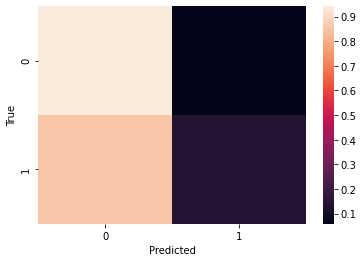

In [11]:
conf = confusion_matrix(y_test, clf.predict(X_test), normalize='true')

ax = plt.axes()
heatmap(conf, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [12]:
np.bincount(labels)

array([135,  14])